In [1]:
from sklearn.datasets import fetch_california_housing

# Step 1: Load dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target
print("Data shape:", X.shape)
print("Target shape:", y.shape)

from sklearn.model_selection import train_test_split

# Step 2: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 3: Initialize and train the model
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = regressor.predict(X_test)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)



Data shape: (20640, 8)
Target shape: (20640,)
Training data shape: (16512, 8)
Testing data shape: (4128, 8)
Mean Squared Error: 0.4997071473927568
R² Score: 0.6186632145457622


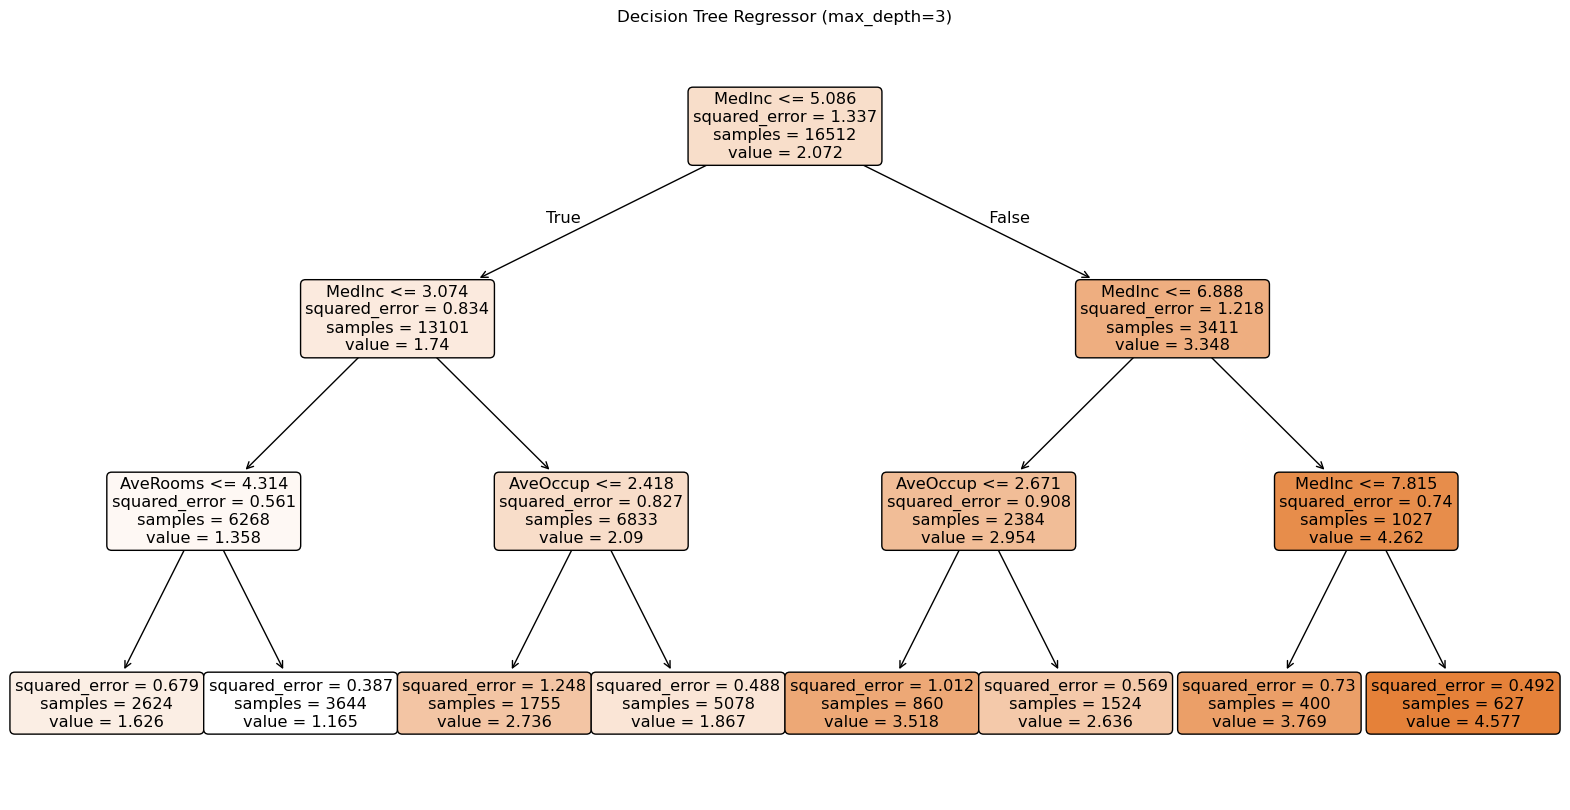

In [2]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set a smaller tree for clarity if it's too large
regressor_small = DecisionTreeRegressor(max_depth=3, random_state=42)
regressor_small.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(regressor_small, 
          feature_names=housing.feature_names, 
          filled=True, 
          rounded=True)
plt.title("Decision Tree Regressor (max_depth=3)")
plt.show()


Custom Decision Tree Regressor Results:
MSE: 0.6424109810265639
R² Score: 0.509762988735822


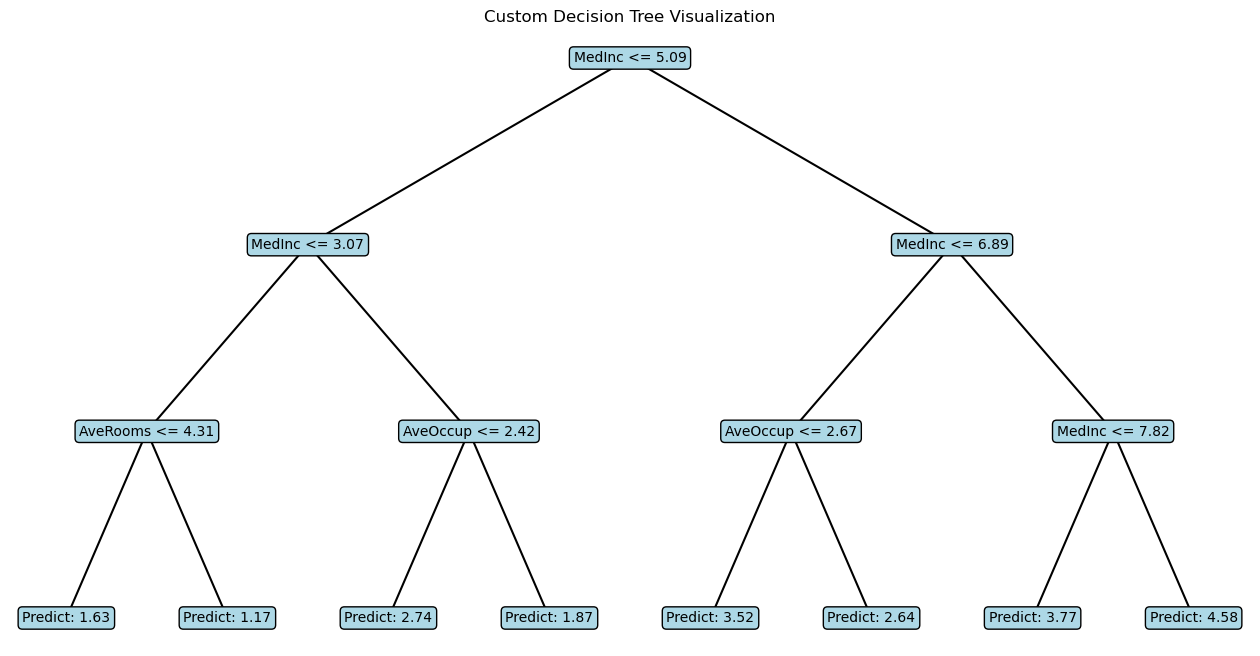

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Build Tree Functions with Fixes
def calculate_mse(y):
    if len(y) == 0:
        return 0
    mean = np.mean(y)
    return np.mean((y - mean) ** 2)

def split_dataset(X, y, feature_idx, threshold):
    left_mask = X[:, feature_idx] <= threshold
    right_mask = X[:, feature_idx] > threshold
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

def find_best_split(X, y):
    best_mse = float('inf')
    best_feature = None
    best_threshold = None

    for feature_idx in range(X.shape[1]):
        values = np.unique(X[:, feature_idx])
        if len(values) <= 1:
            continue
        thresholds = (values[:-1] + values[1:]) / 2

        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature_idx, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            mse = (len(y_left) * calculate_mse(y_left) + len(y_right) * calculate_mse(y_right)) / len(y)
            if mse < best_mse:
                best_mse = mse
                best_feature = feature_idx
                best_threshold = threshold

    return best_feature, best_threshold

def build_tree(X, y, depth=0, max_depth=3, min_samples_split=10):
    if len(y) == 0:
        return 0  # Return default prediction

    if depth >= max_depth or len(y) < min_samples_split or np.all(y == y[0]):
        return float(np.mean(y))

    feature, threshold = find_best_split(X, y)
    if feature is None:
        return float(np.mean(y))

    X_left, y_left, X_right, y_right = split_dataset(X, y, feature, threshold)

    return {
        'feature': feature,
        'threshold': threshold,
        'left': build_tree(X_left, y_left, depth + 1, max_depth, min_samples_split),
        'right': build_tree(X_right, y_right, depth + 1, max_depth, min_samples_split)
    }

# Tree Visualization Functions
def calculate_positions(tree, depth=0, x=0.5, width=1.0, positions=None, connections=None):
    if positions is None:
        positions = {}
    if connections is None:
        connections = []

    if isinstance(tree, dict):
        node_id = id(tree)
        positions[node_id] = (x, -depth)

        left_x = x - width / 4
        right_x = x + width / 4

        connections.append((node_id, id(tree['left'])))
        connections.append((node_id, id(tree['right'])))

        calculate_positions(tree['left'], depth + 1, left_x, width / 2, positions, connections)
        calculate_positions(tree['right'], depth + 1, right_x, width / 2, positions, connections)
    else:
        node_id = id(tree)
        positions[node_id] = (x, -depth)

    return positions, connections


def predict_tree(tree, x):
    if not isinstance(tree, dict):
        return tree  # It's a leaf node with a predicted value
    if x[tree['feature']] <= tree['threshold']:
        return predict_tree(tree['left'], x)
    else:
        return predict_tree(tree['right'], x)

def predict_batch(tree, X):
    return np.array([predict_tree(tree, x) for x in X])


def draw_tree(tree, feature_names):
    positions, connections = calculate_positions(tree)
    fig, ax = plt.subplots(figsize=(16, 8))

    for parent, child in connections:
        x1, y1 = positions[parent]
        x2, y2 = positions[child]
        ax.plot([x1, x2], [y1, y2], 'k-')

    for node_id, (x, y) in positions.items():
        label = ""
        found = False

        def find_node(tree):
            nonlocal label, found
            if id(tree) == node_id:
                found = True
                if isinstance(tree, dict):
                    label = f"{feature_names[tree['feature']]} <= {tree['threshold']:.2f}"
                else:
                    try:
                        label = f"Predict: {float(tree):.2f}"
                    except:
                        label = "Predict: N/A"
            elif isinstance(tree, dict):
                find_node(tree['left'])
                find_node(tree['right'])

        find_node(tree)

        if not label:
            label = "Unknown"

        ax.text(x, y, label, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', edgecolor='black'))

    ax.set_axis_off()
    plt.title("Custom Decision Tree Visualization")
    plt.show()

# Train custom tree and visualize
custom_tree = build_tree(X_train, y_train, max_depth=3, min_samples_split=10)
from sklearn.metrics import mean_squared_error, r2_score

# Predict using the custom tree
y_pred_custom = predict_batch(custom_tree, X_test)

# Evaluate performance
print("Custom Decision Tree Regressor Results:")
print("MSE:", mean_squared_error(y_test, y_pred_custom))
print("R² Score:", r2_score(y_test, y_pred_custom))


draw_tree(custom_tree, housing.feature_names)
